# Project 3 - Reddit API and Classification

## Data Cleaning and EDA

In [2]:
# imports.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
# Reading scraped data from Cheap_Meals subreddit.
cheap = pd.read_csv('./data/cheap.csv')

# Reading scraped data from EatCheapAndHealthy subreddit.
healthy = pd.read_csv('./data/healthy.csv')

In [4]:
print(cheap.shape)
print(healthy.shape)

(686, 3)
(750, 3)


#### Combine subreddits into one dataframe for data cleaning and EDA

In [5]:
df = pd.concat([cheap, healthy], ignore_index=True)
df.shape

(1436, 3)

In [6]:
df.head()

,title,text,subreddit
0,Ancho Chile Puree Braised Chicken Tacos // Tac...,NaN,Cheap_Meals
1,Recipes for College Student,I'm going to be in an off campus apartment tha...,Cheap_Meals
2,Fluffy Apple Roll Cake,NaN,Cheap_Meals
3,Easy Potato Curry,NaN,Cheap_Meals
4,Budget-friendly Korean Soft Tofu Stew!,NaN,Cheap_Meals


In [7]:
df.tail()

,title,text,subreddit
1431,how much do you pay for a dozen eggs where you...,just curious to see how much it varies.\n\ni c...,EatCheapAndHealthy
1432,What to make with chia flour?,I thought I could mix it into yoghurt but it w...,EatCheapAndHealthy
1433,True 30 min hands on time meals?,"I feel like most ""quick weeknight meals"" take ...",EatCheapAndHealthy
1434,Walmart substituted sprouts for two large head...,NaN,EatCheapAndHealthy
1435,What are some good salad recipes for breakfast...,I live in Bangladesh and A LOT of ingredients ...,EatCheapAndHealthy


#### Check null values

In [8]:
healthy.isnull().sum()

title         0
text         47
subreddit     0
dtype: int64

In [9]:
cheap.isnull().sum()

title          0
text         664
subreddit      0
dtype: int64

In [10]:
# Percentage of posts from Cheap_Meals subreddit without text.
664/686

0.967930029154519

> Almost 97% of posts from Cheap_Meals subreddit do not contain text.

#### Drop text feature since majority of posts from Cheap_Meals subreddit do not have text

In [11]:
df.drop('text', axis=1, inplace=True)

In [12]:
# check text feature dropped.
print(df.shape)
df.head()

(1436, 2)


,title,subreddit
0,Ancho Chile Puree Braised Chicken Tacos // Tac...,Cheap_Meals
1,Recipes for College Student,Cheap_Meals
2,Fluffy Apple Roll Cake,Cheap_Meals
3,Easy Potato Curry,Cheap_Meals
4,Budget-friendly Korean Soft Tofu Stew!,Cheap_Meals


#### Keep only lower case letters in title values

In [13]:
import string
df['title'] = df.title.map(lambda x: ''.join([y for y in list(x.lower()) if y in string.ascii_lowercase+" -'"]))
df['title'] = df['title'].map(lambda x: x.replace('-',' '))

In [14]:
df.head()

,title,subreddit
0,ancho chile puree braised chicken tacos taco ...,Cheap_Meals
1,recipes for college student,Cheap_Meals
2,fluffy apple roll cake,Cheap_Meals
3,easy potato curry,Cheap_Meals
4,budget friendly korean soft tofu stew,Cheap_Meals


#### Binarize subreddit target column

>Cheap_Meals: 1,
<br>EatCheapAndHealthy: 0

In [15]:
df.subreddit = df.subreddit.map({'Cheap_Meals':1,
                                'EatCheapAndHealthy':0})

In [16]:
# check target column binarized.
df.subreddit.value_counts()

0    750
1    686
Name: subreddit, dtype: int64

In [17]:
target = df[["subreddit"]]["subreddit"].values
target

array([1, 1, 1, ..., 0, 0, 0])

#### Feature Engineering

In [18]:
# create word count feature.
df['word_count'] = df['title'].apply(lambda x: len(x.split()))

In [19]:
# create character count feature.
df['char_count'] = df['title'].apply(lambda x: len(x))

In [20]:
df.head()

,title,subreddit,word_count,char_count
0,ancho chile puree braised chicken tacos taco ...,1,9,56
1,recipes for college student,1,4,27
2,fluffy apple roll cake,1,4,22
3,easy potato curry,1,3,17
4,budget friendly korean soft tofu stew,1,6,37


#### Distributions of word and character counts

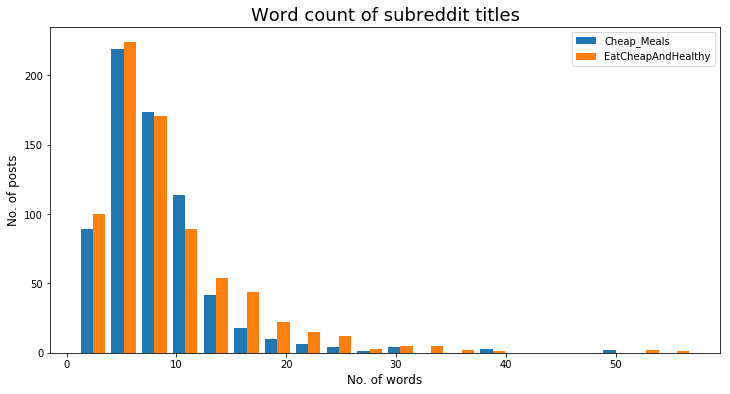

In [21]:
fig = plt.figure(figsize = (12,6))

cheap_mask = df['subreddit'] == 1
healthy_mask = df['subreddit'] == 0

plt.hist([df[cheap_mask]['word_count'], df[healthy_mask]['word_count']],
        bins = 20)

plt.legend(['Cheap_Meals', 'EatCheapAndHealthy'])
plt.title('Word count of subreddit titles', size=18)
plt.xlabel('No. of words', size = 12)
plt.ylabel('No. of posts', size = 12) ;

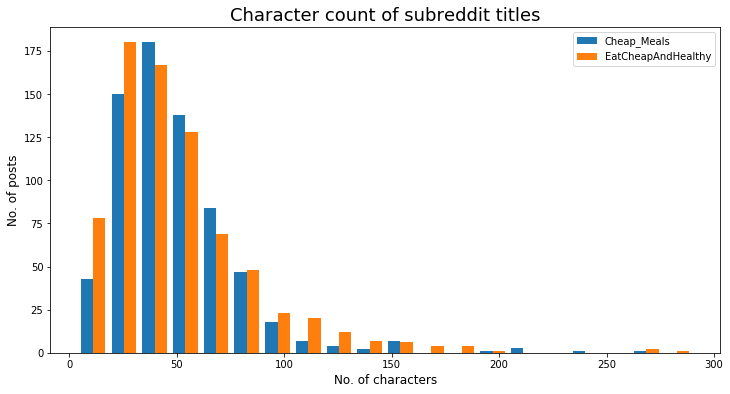

In [22]:
fig = plt.figure(figsize = (12,6))

cheap_mask = df['subreddit'] == 1
healthy_mask = df['subreddit'] == 0

plt.hist([df[cheap_mask]['char_count'], df[healthy_mask]['char_count']],
        bins = 20)

plt.legend(['Cheap_Meals', 'EatCheapAndHealthy'])
plt.title('Character count of subreddit titles', size=18)
plt.xlabel('No. of characters', size = 12)
plt.ylabel('No. of posts', size = 12) ;

> The distributions of word and character count for titles from both subreddits appear to follow a similar distribution and right skewed.

#### TF-IDF

In [31]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))

tfidf_matrix = tfidf.fit_transform(df['title'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

In [34]:
tfidf_df['subreddit'] = df['subreddit']

In [38]:
tfidf_df.groupby('subreddit').mean().T.sort_values(0, ascending = False).head(10)

subreddit,0,1
healthy,0.020640,0.004133
cheap,0.018998,0.012987
recipes,0.018314,0.003057
meals,0.015769,0.002559
meal,0.013763,0.003857
need,0.011577,0.001033
good,0.011115,0.001036
ideas,0.011090,0.001245
cheap healthy,0.010117,0.000345
help,0.010063,0.000891


In [39]:
tfidf_df.groupby('subreddit').mean().T.sort_values(1, ascending = False).head(10)

subreddit,0,1
recipe,0.005401,0.031077
chicken,0.007226,0.027440
easy,0.008420,0.022758
curry,0.000848,0.015765
make,0.007849,0.015151
food,0.008439,0.013861
fish,0.002477,0.013072
cheap,0.018998,0.012987
street,0.000000,0.011657
street food,0.000000,0.010943


>The words with the highest mean TF-IDF values for each subreddit seem to differ, making TF-IDF a good feature for modelling.

#### Sentiment Analysis

In [23]:
analyzer =  SentimentIntensityAnalyzer()

In [25]:
sentiments = []

for t in list(df['title']):
    sentiment = analyzer.polarity_scores(t)
    sentiment['title'] = t
    sentiments.append(sentiment)
    
sen = pd.DataFrame(sentiments)

In [26]:
sen.head()

,compound,neg,neu,pos,title
0,0.0000,0.0,1.000,0.000,ancho chile puree braised chicken tacos taco ...
1,0.0000,0.0,1.000,0.000,recipes for college student
2,0.0000,0.0,1.000,0.000,fluffy apple roll cake
3,0.4404,0.0,0.408,0.592,easy potato curry
4,0.4939,0.0,0.610,0.390,budget friendly korean soft tofu stew


In [27]:
sen['subreddit'] = df['subreddit']
sen.head()

,compound,neg,neu,pos,title,subreddit
0,0.0000,0.0,1.000,0.000,ancho chile puree braised chicken tacos taco ...,1
1,0.0000,0.0,1.000,0.000,recipes for college student,1
2,0.0000,0.0,1.000,0.000,fluffy apple roll cake,1
3,0.4404,0.0,0.408,0.592,easy potato curry,1
4,0.4939,0.0,0.610,0.390,budget friendly korean soft tofu stew,1


In [40]:
sen.groupby('subreddit').mean()

,compound,neg,neu,pos
subreddit,,,,
0,0.158120,0.043825,0.813628,0.142551
1,0.152548,0.016305,0.868908,0.114787


>Higher negative sentiment score is observed for the EatCheapAndHealthy subreddit, while the rest of the scores are roughly comparable.

In [42]:
df['neg_sen'] = sen['neg']

In [43]:
df['pos_sen'] = sen['pos']

In [46]:
df.to_csv("./data/df_clean.csv", index=False)

In [45]:
df.head()

,title,subreddit,word_count,char_count,neg_sen,pos_sen
0,ancho chile puree braised chicken tacos taco ...,1,9,56,0.0,0.000
1,recipes for college student,1,4,27,0.0,0.000
2,fluffy apple roll cake,1,4,22,0.0,0.000
3,easy potato curry,1,3,17,0.0,0.592
4,budget friendly korean soft tofu stew,1,6,37,0.0,0.390
